# NLP Shap Notebook 3
## Author: Kevin

This notebook does analysis individual instances of movie reviews, and looks at different combinations of genres.

- [Part 1](#scrollTo=KRBk_Kxe33sk&line=3&uniqifier=1): Analysis of correctly predicted genres/rating for single review.
- [Part 2](#scrollTo=xZaGStpKpJ46&line=7&uniqifier=1): Analysis of incorrectly predicted genres/rating for a single review.
- [Part 3](#scrollTo=UN031_qX1mcX&line=3&uniqifier=1): Analysis of removal of global important features for prediction of particular genre for a single review.
- [Part 4](#scrollTo=nP3UuC1Hd1jS&line=3&uniqifier=1): Analysis of removal of locally important features for prediction of particular genre for a single review.

In [1]:
#housekeeping steps
from google.colab import drive
drive.mount('/content/drive')

!pip install shap
!pip install lime

import pandas as pd
%tensorflow_version 1.13.1
import tensorflow as tf
from tensorflow.keras.preprocessing import text
import keras.backend.tensorflow_backend as K
K.set_session
import matplotlib.pyplot as plt
import shap
import numpy
import sklearn.metrics as skm
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tqdm import tqdm


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.13.1`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


Using TensorFlow backend.


In [2]:
#read in presaved and preformatted text and baseline model shap values

text_train_path = "/content/drive/My Drive/test_data/text_train.csv"
text_test_path = "/content/drive/My Drive/test_data/text_test.csv"
y_train_path = "/content/drive/My Drive/test_data/y_train.csv"
y_test_path = "/content/drive/My Drive/test_data/y_test.csv"

text_train = pd.read_csv(text_train_path, names=['text'])
text_test = pd.read_csv(text_test_path, names=['text'])
y_train = pd.read_csv(y_train_path)
y_test = pd.read_csv(y_test_path)

print(text_train.shape, text_test.shape, y_train.shape, y_test.shape)

baseline_model_shap_vals = numpy.load("/content/drive/My Drive/test_data/shap_vals.npy")

(39004, 1) (9751, 1) (39004, 23) (9751, 23)


In [3]:
#define set of helper functions

class TextPreprocessor(object):
    def __init__(self, vocab_size):
        self._vocab_size = vocab_size
        self._tokenizer = None
    def create_tokenizer(self, text_list):
        tokenizer = text.Tokenizer(num_words = self._vocab_size)
        tokenizer.fit_on_texts(text_list)
        self._tokenizer = tokenizer
    def transform_text(self, text_list):
        text_matrix = self._tokenizer.texts_to_matrix(text_list)
        return text_matrix

def read_data():
  """Load presaved and preformated text from google drive.
  Returns:
    text_train {pandas.DataFrame}: Train set of text reviews.
    text_test {pandas.DataFrame}: Test set of text reviews.
    y_train {pandas.DataFrame}: Ground truth labels for text_train.
    y_test {pandas.DataFrame}: Ground truth labels for text_test.
    """
  text_train_path = "/content/drive/My Drive/test_data/text_train.csv"
  text_test_path = "/content/drive/My Drive/test_data/text_test.csv"
  y_train_path = "/content/drive/My Drive/test_data/y_train.csv"
  y_test_path = "/content/drive/My Drive/test_data/y_test.csv"

  text_train = pd.read_csv(text_train_path, names=['text'])
  text_test = pd.read_csv(text_test_path, names=['text'])
  y_train = pd.read_csv(y_train_path)
  y_test = pd.read_csv(y_test_path)

  return text_train, text_test, y_train, y_test




def preprocess_text(vocab_size, x_train_text, x_test_text, text_processor):
  """Instatiates an instance of TextPreProcessor class and transforms training 
  and testing text splits.
  Arguments:
    vocab_size {int}: Size of resulting tokenized train and test splits.
    x_train_text {pandas.DataFrame or pandas.Series}: Training set of text to tokenize.
    x_test_text {pandas.DataFrmae}: Testing set of text to tokenize.
    text_processor {class '__main__.TextPreprocessor'}: Tokenizer to tokenize train/test text splits.
  Returns:
    X_train {numpy.ndarray}: Tokenized/OHE text training split.
    X_test {numpy.ndarray}: Tokenized/OHE text test split.
    """
  #if removing words from text_train, it will be a pd.Series
  if isinstance(x_train_text, pd.Series):
    text_processor.create_tokenizer(x_train_text.iloc[:])
    X_train = text_processor.transform_text(x_train_text.iloc[:])
  else:
    #train_post = merged['Body'].values[: train_size]
    #test_post = merged['Body'].values[train_size: ]
    text_processor.create_tokenizer(x_train_text.iloc[:, -1])
    X_train = text_processor.transform_text(x_train_text.iloc[:, -1])
  
  X_test = text_processor.transform_text(x_test_text.iloc[:, -1])
  return X_train, X_test
  
def word_lookup_creation(processor):
  """Creates a mapping between original text and resulting words in text training split.
  Returns:
    words {dict}: Dictionary where keys are particular word in vocabulary,
                  and value is the index of said word (E.g. {'person': 1, 'gpe': 2 }).
    word_lookup {list}: List of words ordered by their index position of length vocabulary size 
                        (E.g. ['person', 'gpe',...])
                        """ 
                
  words = processor._tokenizer.word_index
  word_lookup = list()
  for i in words.keys():
      word_lookup.append(i)
  word_lookup = [''] + word_lookup
  return words, word_lookup
  
def create_model(input_shape, num_tags):
  """Instantiates a text classifier and returns it.
  Arguments:
    input_shape {int}: Size of input array, typically the vocabulary size.
    num_tags {int}: ???
  Returns:
    model {tf.keras.Sequential}: Instantiated model to be trained.  
    """
  tf.random.set_random_seed(2020)
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(50, input_shape = (input_shape,), activation='relu'))
  model.add(tf.keras.layers.Dense(25, activation='relu'))
  model.add(tf.keras.layers.Dense(num_tags, activation='sigmoid'))
  model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
  return model

def train_and_score(model, train_data_X, train_data_y, test_data_X, test_data_y, 
                    n_epochs, batch_size):
  """Train text classifier on particular set of text and print evaluation metrics.
  Arguments:
    model {tf.keras.Sequential}: Instantiated model to be trained.
    train_data_X {numpy.ndarray}: Training text data.
    train_data_y {numpy.ndarray}: Training text labels.
    test_data_X {numpy.ndarray}: Testing text data.
    test_data_y {numpy.ndarray}: Testing text labels.
    n_epochs {int}: Number of epochs to train through.
    batch_size {int}: Batch size to train on.
    """
  model.fit(train_data_X, train_data_y, epochs=n_epochs, batch_size=batch_size, 
            validation_split=0.1)
  print('Eval loss/accuracy:{}'.format(model.evaluate(test_data_X, test_data_y,
                                                      batch_size = batch_size)))

  return model




def shap_vals_calculation(n_examples:int, n_explanations:int, 
                          x_train:numpy.ndarray, x_test:numpy.ndarray,
                          model:tf.python.keras.engine.sequential.Sequential):
  """Calculates shap values of corresponing text classifier.
  Arguments:
    n_examples {int}: Number of examples to integrate over.
    n_eplanations {int}: Number of explanations to create. 
    x_train {numpy.ndarray}: Training set.
    x_test {numpy.ndarray}: Testing set to create shap value explantions for.
    model {tf.keras.Sequential}: Trained model to evaluate.
  Returns:
    shap_vals {tuple}: tuple of shap values of shape:
                       ((n_explantions, vocabulary size) x # of classes)
    explainer {shap.explainer.Explainer}: Explainer object???
    """
  attrib_data = x_train[:n_examples]
  explainer = shap.DeepExplainer(model, attrib_data)
  shap_vals = explainer.shap_values(x_test[:n_explanations])
  return shap_vals, explainer

def display_shap_figures(shap_values, x_test, word_lookup_reference):
  """Displays shap global summary plot and summary plot for each individual class/genre.
  Arguments:
    shap_values {list}: List of calculated shap values.
    x_test {numpy.ndarray}: Testing split to display explanations about.
    word_lookup_reference {list}: list of words in vocabulary ordered by index position 
                                  to display on figures.
                                  """

  shap.summary_plot(shap_values, feature_names=word_lookup_reference, 
                    class_names=y_train.columns)

  for i in range(len(shap_values)):
    print(y_test.columns[i])
    shap.summary_plot(shap_values[i], x_test[:shap_values[0].shape[0]],
                      feature_names=word_lookup_reference, 
                      class_names=y_train.columns)






  

In [4]:
#main function to train model on specified datasets. 
#make list of features to remove from training sets and retrain
#model for performance comparison

def main(vocab_size=2000, drop_features=None):

  #read in presaved data
  text_train, text_test, y_train, y_test = read_data()
  num_tags = y_test.shape[1]
  
  #remove predefined words in drop_features from corpus.
  print("[INFO] Removing words from text...\n")
  if drop_features:
    for w in drop_features:
      new_text_train = pd.Series([" ".join(word for word in x.split() if \
                  word not in drop_features) for x in text_train.text])
  else:
    new_text_train = text_train
  
  #instantiate Tokenizer and tokenize train and test splits.
  print("[INFO] Processing Text...\n")
  processor = TextPreprocessor(vocab_size=vocab_size)
  X_train, X_test = preprocess_text(vocab_size=vocab_size, x_train_text=new_text_train,
                                    x_test_text=text_test, text_processor=processor)
  
  #create word_index reference for future figures. 
  word_dict, word_lookup = word_lookup_creation(processor=processor)

  
  #instantiate and train model on train split.
  print("[INFO] Creating and Training Model...\n")
  model = create_model(input_shape=vocab_size, num_tags=num_tags)
  
  trained_model = train_and_score(model, train_data_X=X_train, train_data_y=y_train, 
                                  test_data_X=X_test, test_data_y=y_test,
                                  n_epochs=10, batch_size=128)
  
  #make predictions for confusion matrix and classification report
  y_pred = trained_model.predict(X_test)
  
  print("[INFO] Displaying Confusion Matrix ...\n")
  cm = skm.multilabel_confusion_matrix(y_test.values, y_pred.round(0))
  #reformat confusion matrix as pandas DataFrame for prettier formatting
  cm_df = pd.DataFrame(cm.reshape(cm.shape[0], -1), columns=['TN', 'FP', 'FN', 'TP'], 
                        index=y_test.columns)
  print(cm_df, "\n")

  #print classfication report
  print("[INFO] Displaying Classification Report...\n")
  print(skm.classification_report(y_test.values, y_pred.round(0), target_names=cm_df.index))

  #calculate shap values; n_examples=500 and n_explantions=50 
  #for relatively easy and quick computation
  print("[INFO] Calculating Shap Values...\n")
  shap_vals, exp = shap_vals_calculation(n_examples=500, n_explanations=50, 
                                      x_train=X_train, x_test=X_test, 
                                      model=trained_model)
  print("[INFO] Finished...")
  
  return shap_vals, exp, word_lookup, y_pred

In [5]:
#main() without removing words
sv, exp, wl, yp = main()
shap_matrix = numpy.stack(sv)

[INFO] Removing words from text...

[INFO] Processing Text...

[INFO] Creating and Training Model...

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 35103 samples, validate on 3901 samples
Epoch 1/10
35103/35103 [==============================] - 2s 51us/sample - loss: 0.2401 - acc: 0.8944 - val_loss: 0.0966 - val_acc: 0.9626
Epoch 2/10
35103/35103 [==============================] - 2s 48us/sample - loss: 0.0780 - acc: 0.9694 - val_loss: 0.0651 - val_acc: 0.9739
Epoch 3/10
35103/35103 [==============================] - 2s 48us/sample - loss: 0.0592 - acc: 0.9759 - val_loss: 0.0570 - val_acc: 0.9762
Epoch 4/10
35103/35103 [==============================] - 2s 47us/sample - loss: 0.0515 - acc: 0.9783 - val_loss: 0.0535 - val_acc: 0.9769
Epoch 5/10
35103/35103 [==============================] - 2s 49us/sample - loss: 0.0474 - acc: 0.9798 - val_loss: 0.05

Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
keras is no longer supported, please use tf.keras instead.


[INFO] Finished...


#  Part 1: 

##Analysis of Correct Predictions

### Waterfall plots displaying explanations of correctly predicted genres.

### What parts of the review led our classifier to __correctly__ predict the genres?

- Take 3 instances: 5th, 15th, 30th instance in X_test
- Shap Waterfall plot of words that contribute to prediction of _correct_ genres. 


In [6]:
#reference 
columns_idx_dict = dict(zip(y_test.columns, range(len(y_test.columns))))
def plot_waterfall(i:int, columns:list, explainer=exp, 
                   shap_values=shap_matrix, word_list=wl, y_preds=yp):
  shap.initjs()
  print(f"Ground Truth: \n{y_test.iloc[i, :]}")
  print(f"\nPredictions (Top 6): \n {sorted(dict(zip(y_train.columns, y_preds[i][:])).items(), key=lambda x: x[1], reverse=True)[:6]}")
  print(f"\nReview text: \n{text_test.iloc[i]}\n")
  for c in columns: 
    print(f"Genre: {[key  for (key, value) in columns_idx_dict.items() if value == c]}")
    shap.waterfall_plot(explainer.expected_value[c], shap_values[c][i], word_list[:2000])



In [7]:
print(columns_idx_dict)

{'Action and Adventure': 0, 'Animation': 1, 'Anime and Manga': 2, 'Art House and International': 3, 'Classics': 4, 'Comedy': 5, 'Cult Movies': 6, 'Documentary': 7, 'Drama': 8, 'Faith and Spirituality': 9, 'Gay and Lesbian': 10, 'Horror': 11, 'Kids and Family': 12, 'Musical and Performing Arts': 13, 'Mystery and Suspense': 14, 'Romance': 15, 'Science Fiction and Fantasy': 16, 'Special Interest': 17, 'Sports and Fitness': 18, 'Television': 19, 'Western': 20, 'fresh': 21, 'rotten': 22}


Ground Truth: 
Action and Adventure           0.0
Animation                      0.0
Anime and Manga                0.0
Art House and International    0.0
Classics                       0.0
Comedy                         1.0
Cult Movies                    0.0
Documentary                    0.0
Drama                          1.0
Faith and Spirituality         0.0
Gay and Lesbian                0.0
Horror                         0.0
Kids and Family                0.0
Musical and Performing Arts    0.0
Mystery and Suspense           0.0
Romance                        1.0
Science Fiction and Fantasy    0.0
Special Interest               0.0
Sports and Fitness             0.0
Television                     0.0
Western                        0.0
fresh                          0.0
rotten                         1.0
Name: 5, dtype: float64

Predictions (Top 6): 
 [('Romance', 0.9999998), ('Comedy', 0.9999623), ('Drama', 0.9988145), ('rotten', 0.48665002), ('fresh', 0.34942758), ('Classics', 0.

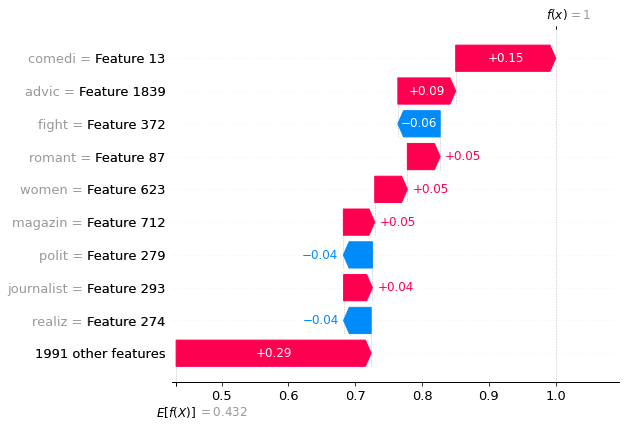

Genre: ['Drama']


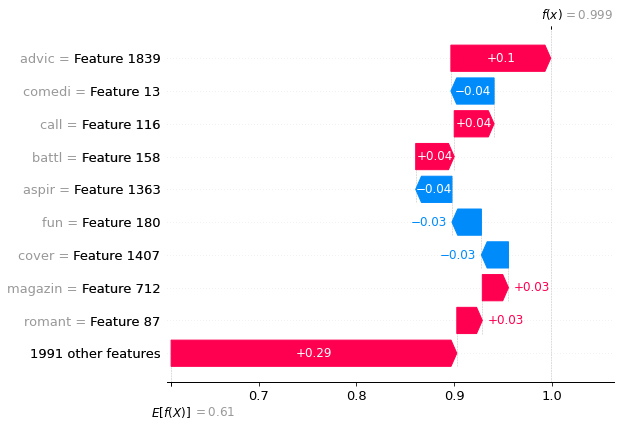

Genre: ['Romance']


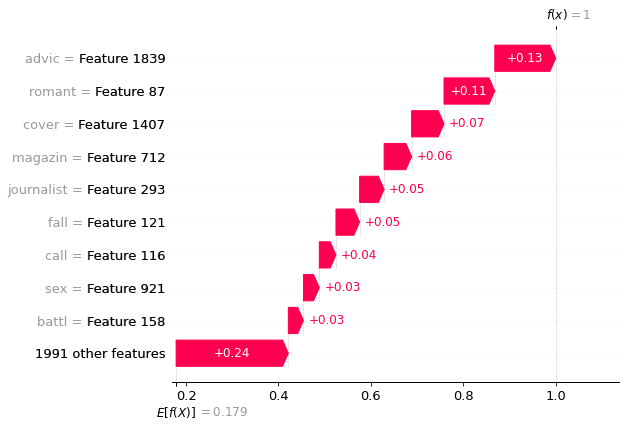

Genre: ['rotten']


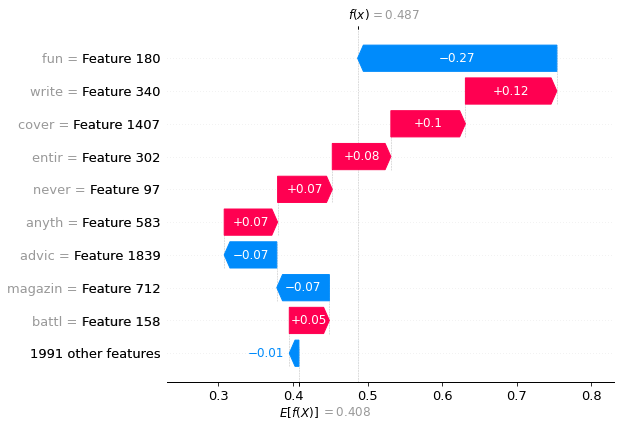

In [8]:
#i = 5
cs = [columns_idx_dict[c] for c in ['Comedy', 'Drama', 'Romance', 'rotten']]
plot_waterfall(i=5, columns=cs, explainer=exp, shap_values=shap_matrix, 
               word_list = wl, y_preds=yp)

Ground Truth: 
Action and Adventure           0.0
Animation                      0.0
Anime and Manga                0.0
Art House and International    1.0
Classics                       0.0
Comedy                         1.0
Cult Movies                    0.0
Documentary                    0.0
Drama                          1.0
Faith and Spirituality         0.0
Gay and Lesbian                0.0
Horror                         0.0
Kids and Family                0.0
Musical and Performing Arts    0.0
Mystery and Suspense           0.0
Romance                        0.0
Science Fiction and Fantasy    0.0
Special Interest               0.0
Sports and Fitness             0.0
Television                     0.0
Western                        0.0
fresh                          1.0
rotten                         0.0
Name: 15, dtype: float64

Predictions (Top 6): 
 [('Drama', 0.99999994), ('Art House and International', 0.99566823), ('Comedy', 0.9927895), ('fresh', 0.9613061), ('rotten', 0.0543

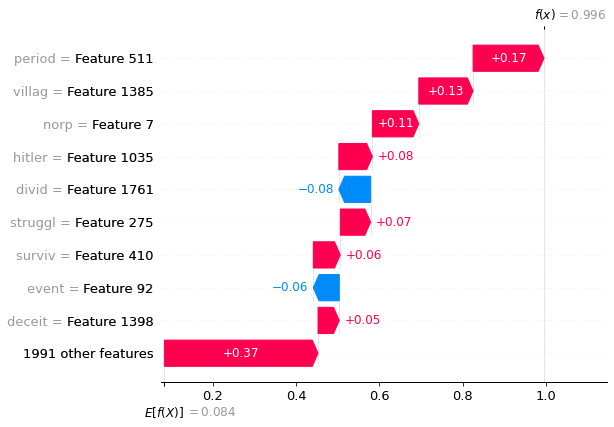

Genre: ['Drama']


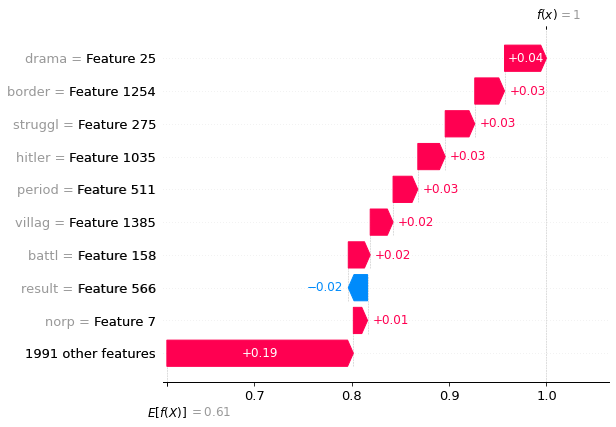

Genre: ['fresh']


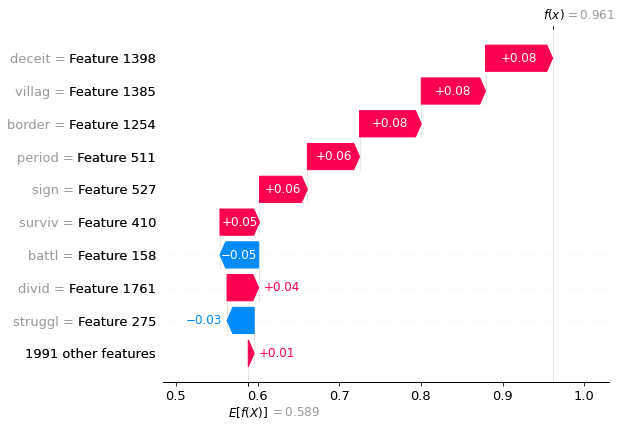

In [9]:
#i = 15
cs = [columns_idx_dict[c] for c in ['Art House and International', 'Drama', 'fresh']]
plot_waterfall(i=15, columns=cs, explainer=exp, shap_values=shap_matrix, 
               word_list = wl)

Ground Truth: 
Action and Adventure           0.0
Animation                      0.0
Anime and Manga                0.0
Art House and International    0.0
Classics                       0.0
Comedy                         1.0
Cult Movies                    0.0
Documentary                    1.0
Drama                          0.0
Faith and Spirituality         0.0
Gay and Lesbian                0.0
Horror                         0.0
Kids and Family                0.0
Musical and Performing Arts    0.0
Mystery and Suspense           0.0
Romance                        0.0
Science Fiction and Fantasy    0.0
Special Interest               0.0
Sports and Fitness             0.0
Television                     0.0
Western                        0.0
fresh                          1.0
rotten                         0.0
Name: 30, dtype: float64

Predictions (Top 6): 
 [('Comedy', 0.99963474), ('Documentary', 0.9916262), ('fresh', 0.63505054), ('rotten', 0.3571521), ('Musical and Performing Arts', 

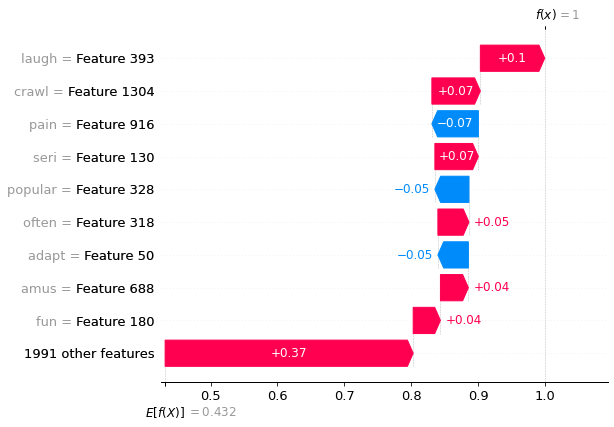

Genre: ['Documentary']


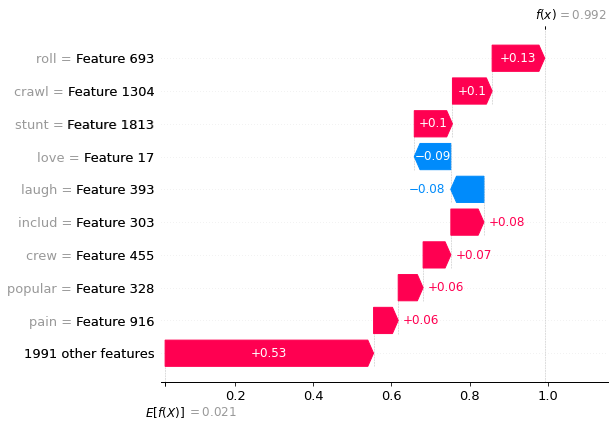

Genre: ['fresh']


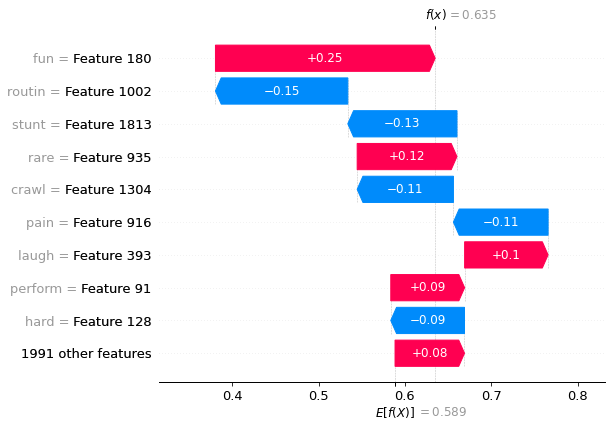

In [10]:
#i = 30
cs = [columns_idx_dict[c] for c in ['Comedy', 'Documentary', 'fresh']]
plot_waterfall(i=30, columns=cs, explainer=exp, shap_values=shap_matrix, 
               word_list = wl)

1. Words like 'laugh', 'seri' (maybe for the word 'series') contribute most to classified as a comedy, in which the classifier was very confident in its prediction.
2. Words like 'roll', 'stunt', 'crew' contribute to classification of documentary, in which the classifier very confident in its prediction. 
3. Classifier was split between rotten/fresh, as there are conflicting words like 'fun' and 'routin' (perhaps for word 'routine')

# Part 2: 
## Analysis of Incorrect predictions

### Which instances does the classifier __incorrectly__ predict a certain genre?


- Take 3 instances: 1st, 10th, 29th instance
- Investigate words that contributed to _incorrect_ prediction of genre. 

Ground Truth: 
Action and Adventure           0.0
Animation                      0.0
Anime and Manga                0.0
Art House and International    0.0
Classics                       0.0
Comedy                         0.0
Cult Movies                    0.0
Documentary                    0.0
Drama                          1.0
Faith and Spirituality         0.0
Gay and Lesbian                0.0
Horror                         0.0
Kids and Family                0.0
Musical and Performing Arts    0.0
Mystery and Suspense           0.0
Romance                        0.0
Science Fiction and Fantasy    0.0
Special Interest               0.0
Sports and Fitness             1.0
Television                     0.0
Western                        0.0
fresh                          0.0
rotten                         1.0
Name: 1, dtype: float64

Predictions (Top 6): 
 [('Drama', 0.99998736), ('Sports and Fitness', 0.9998114), ('fresh', 0.8256311), ('rotten', 0.18542394), ('Documentary', 0.000770717

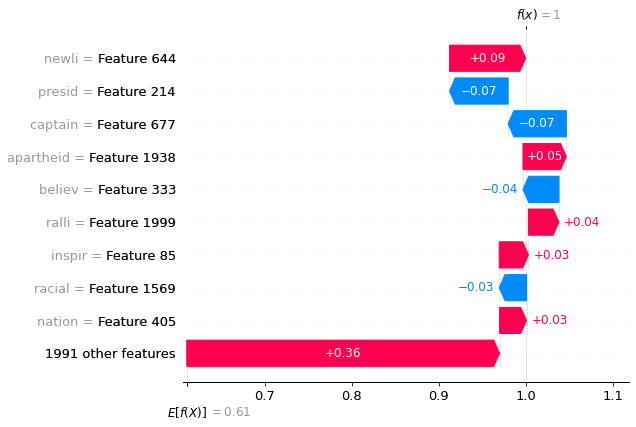

Genre: ['Sports and Fitness']


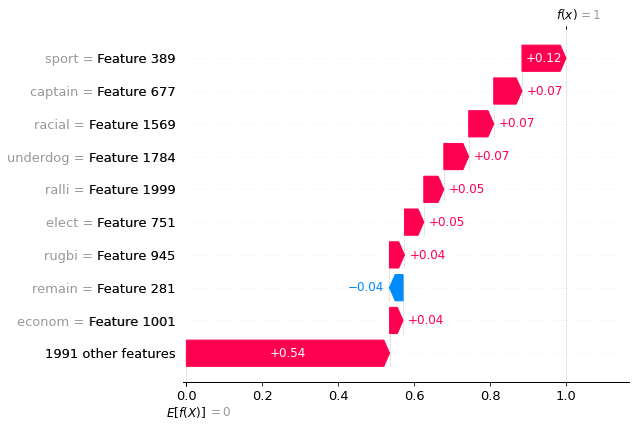

Genre: ['fresh']


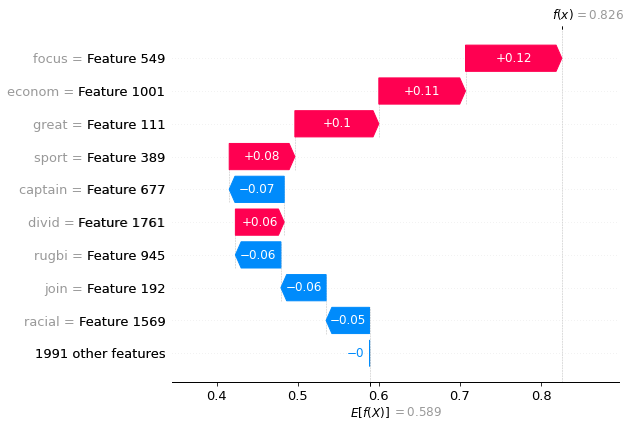

In [11]:
#i=1
cs = [columns_idx_dict[c] for c in ['Drama', 'Sports and Fitness', 'fresh']]
plot_waterfall(i=1, columns=cs, explainer=exp, shap_values=shap_matrix, word_list=wl)

Ground Truth: 
Action and Adventure           0.0
Animation                      0.0
Anime and Manga                0.0
Art House and International    0.0
Classics                       0.0
Comedy                         1.0
Cult Movies                    0.0
Documentary                    0.0
Drama                          0.0
Faith and Spirituality         0.0
Gay and Lesbian                0.0
Horror                         0.0
Kids and Family                0.0
Musical and Performing Arts    0.0
Mystery and Suspense           0.0
Romance                        0.0
Science Fiction and Fantasy    0.0
Special Interest               0.0
Sports and Fitness             0.0
Television                     0.0
Western                        0.0
fresh                          0.0
rotten                         1.0
Name: 10, dtype: float64

Predictions (Top 6): 
 [('Comedy', 0.99977756), ('rotten', 0.5458919), ('fresh', 0.430636), ('Television', 9.560585e-05), ('Musical and Performing Arts', 

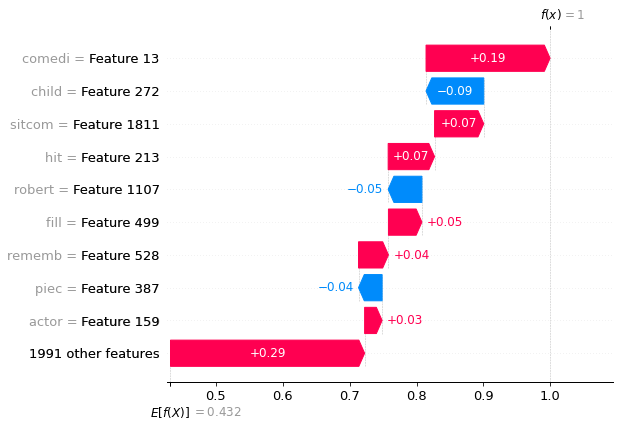

Genre: ['fresh']


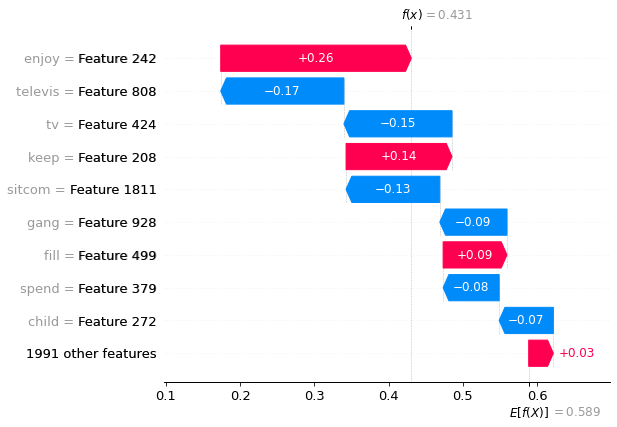

In [12]:
#i=10
cs = [columns_idx_dict[c] for c in ['Comedy', 'fresh']]
plot_waterfall(i=10, columns=cs, explainer=exp, shap_values=shap_matrix, word_list=wl)

Ground Truth: 
Action and Adventure           0.0
Animation                      0.0
Anime and Manga                0.0
Art House and International    0.0
Classics                       0.0
Comedy                         0.0
Cult Movies                    0.0
Documentary                    0.0
Drama                          1.0
Faith and Spirituality         0.0
Gay and Lesbian                0.0
Horror                         0.0
Kids and Family                0.0
Musical and Performing Arts    0.0
Mystery and Suspense           1.0
Romance                        0.0
Science Fiction and Fantasy    0.0
Special Interest               0.0
Sports and Fitness             0.0
Television                     0.0
Western                        0.0
fresh                          0.0
rotten                         1.0
Name: 26, dtype: float64

Predictions (Top 6): 
 [('Drama', 0.99996114), ('Mystery and Suspense', 0.96977913), ('fresh', 0.60585046), ('rotten', 0.37458426), ('Classics', 0.0072041

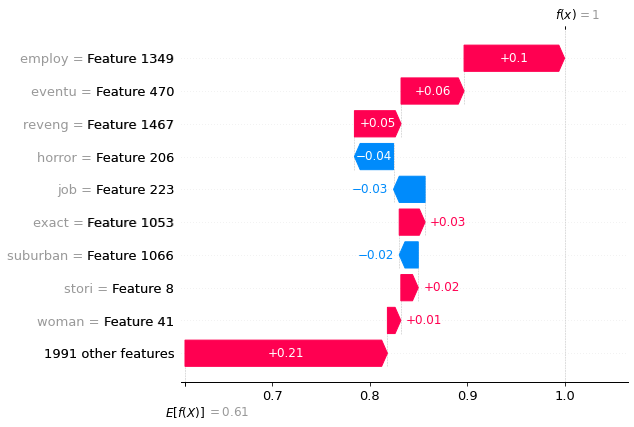

Genre: ['Mystery and Suspense']


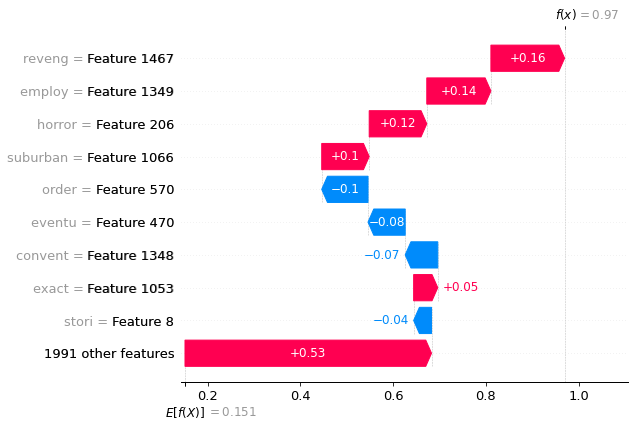

Genre: ['fresh']


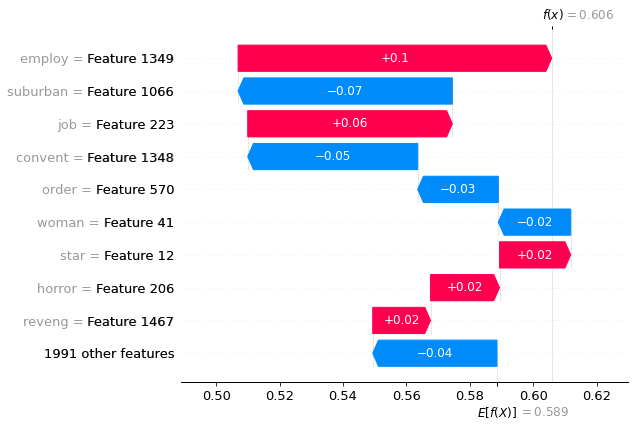

In [13]:
#i=26
cs = [columns_idx_dict[c] for c in ['Drama', 'Mystery and Suspense', 'fresh']]
plot_waterfall(i=26, columns=cs, explainer=exp, shap_values=shap_matrix, word_list=wl)

# Part 3
## Removing words from corpus

### Remove top words from corpus for 'Comedy' and retrain model and recalculate shap values and investigate differences in analysis' with respect to instance #30

In [14]:
sv3, exp3, wl3, yp3 = main(drop_features=['comedi', 'drama', 'thriller', 'director', 'set',
                    'comic', 'live', 'cardin', 'adapt', 'stori', 
                    'attempt', 'man', 'wife', 'young', 'night',
                    'seri', 'colleg', 'date', 'mother', 'back'])
shap_matrix3 = numpy.stack(sv3)

[INFO] Removing words from text...

[INFO] Processing Text...

[INFO] Creating and Training Model...

Train on 35103 samples, validate on 3901 samples
Epoch 1/10
35103/35103 [==============================] - 2s 50us/sample - loss: 0.2592 - acc: 0.8956 - val_loss: 0.1192 - val_acc: 0.9550
Epoch 2/10
35103/35103 [==============================] - 2s 45us/sample - loss: 0.0901 - acc: 0.9651 - val_loss: 0.0710 - val_acc: 0.9718
Epoch 3/10
35103/35103 [==============================] - 2s 46us/sample - loss: 0.0629 - acc: 0.9745 - val_loss: 0.0589 - val_acc: 0.9760
Epoch 4/10
35103/35103 [==============================] - 2s 47us/sample - loss: 0.0531 - acc: 0.9777 - val_loss: 0.0541 - val_acc: 0.9770
Epoch 5/10
35103/35103 [==============================] - 2s 47us/sample - loss: 0.0481 - acc: 0.9795 - val_loss: 0.0518 - val_acc: 0.9775
Epoch 6/10
35103/35103 [==============================] - 2s 47us/sample - loss: 0.0450 - acc: 0.9807 - val_loss: 0.0505 - val_acc: 0.9782
Epoch 7/10
3510

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


[INFO] Finished...


Ground Truth: 
Action and Adventure           0.0
Animation                      0.0
Anime and Manga                0.0
Art House and International    0.0
Classics                       0.0
Comedy                         1.0
Cult Movies                    0.0
Documentary                    1.0
Drama                          0.0
Faith and Spirituality         0.0
Gay and Lesbian                0.0
Horror                         0.0
Kids and Family                0.0
Musical and Performing Arts    0.0
Mystery and Suspense           0.0
Romance                        0.0
Science Fiction and Fantasy    0.0
Special Interest               0.0
Sports and Fitness             0.0
Television                     0.0
Western                        0.0
fresh                          1.0
rotten                         0.0
Name: 30, dtype: float64

Predictions (Top 6): 
 [('Comedy', 0.9996016), ('Documentary', 0.8724612), ('fresh', 0.57025754), ('rotten', 0.45660552), ('Television', 0.00047585368), (

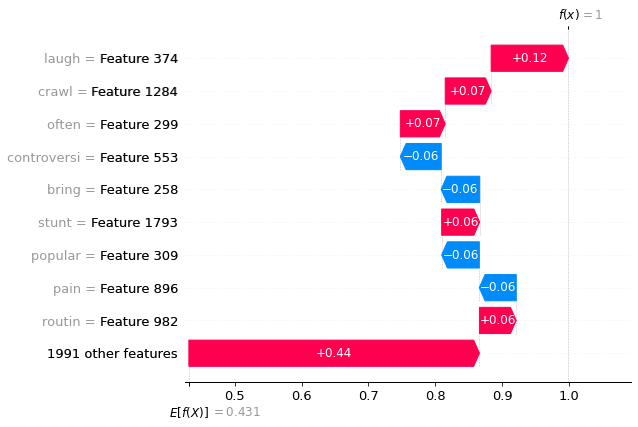

In [15]:
cs3 = [columns_idx_dict[c] for c in ['Comedy']]
plot_waterfall(i=30, columns=cs3, explainer=exp3, shap_values=shap_matrix3, 
               word_list = wl3, y_preds=yp3)

# Part 4
## Remove words for specific instance

### Remove important words for instance #30  and #1

In [17]:
sv41, exp41, wl41, yp41 = main(drop_features=['laugh', 'crawl', 'popular', 'pain', 
                                          'seri', 'adapt', 'often', 'fun', 'stunt'])
shap_matrix41 = numpy.stack(sv41)


[INFO] Removing words from text...

[INFO] Processing Text...

[INFO] Creating and Training Model...

Train on 35103 samples, validate on 3901 samples
Epoch 1/10
35103/35103 [==============================] - 2s 60us/sample - loss: 0.2458 - acc: 0.8932 - val_loss: 0.1062 - val_acc: 0.9600
Epoch 2/10
35103/35103 [==============================] - 2s 46us/sample - loss: 0.0838 - acc: 0.9680 - val_loss: 0.0685 - val_acc: 0.9730
Epoch 3/10
35103/35103 [==============================] - 2s 45us/sample - loss: 0.0613 - acc: 0.9752 - val_loss: 0.0591 - val_acc: 0.9754
Epoch 4/10
35103/35103 [==============================] - 2s 45us/sample - loss: 0.0527 - acc: 0.9779 - val_loss: 0.0535 - val_acc: 0.9768
Epoch 5/10
35103/35103 [==============================] - 2s 44us/sample - loss: 0.0478 - acc: 0.9794 - val_loss: 0.0517 - val_acc: 0.9776
Epoch 6/10
35103/35103 [==============================] - 2s 46us/sample - loss: 0.0449 - acc: 0.9805 - val_loss: 0.0497 - val_acc: 0.9780
Epoch 7/10
3510

Ground Truth: 
Action and Adventure           0.0
Animation                      0.0
Anime and Manga                0.0
Art House and International    0.0
Classics                       0.0
Comedy                         1.0
Cult Movies                    0.0
Documentary                    1.0
Drama                          0.0
Faith and Spirituality         0.0
Gay and Lesbian                0.0
Horror                         0.0
Kids and Family                0.0
Musical and Performing Arts    0.0
Mystery and Suspense           0.0
Romance                        0.0
Science Fiction and Fantasy    0.0
Special Interest               0.0
Sports and Fitness             0.0
Television                     0.0
Western                        0.0
fresh                          1.0
rotten                         0.0
Name: 30, dtype: float64

Predictions (Top 6): 
 [('Documentary', 0.99488986), ('Comedy', 0.9808622), ('rotten', 0.5252673), ('fresh', 0.4937605), ('Musical and Performing Arts', 0

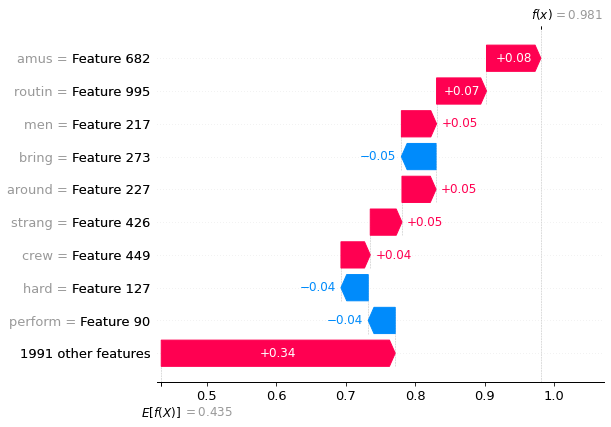

In [18]:
cs41 = [columns_idx_dict[c] for c in ['Comedy']]
plot_waterfall(i=30, columns=cs41, explainer=exp41, shap_values=shap_matrix41, 
               word_list = wl41, y_preds=yp41)

In [20]:
#another example:
sv42, exp42, wl42, yp42 = main(drop_features=['sport', 'captain', 'underdog', 'racial',
                                          'ralli', 'elect', 'rugbi', 'remain', 'econom'])
shap_matrix42 = numpy.stack(sv42)


[INFO] Removing words from text...

[INFO] Processing Text...

[INFO] Creating and Training Model...

Train on 35103 samples, validate on 3901 samples
Epoch 1/10
35103/35103 [==============================] - 2s 60us/sample - loss: 0.2333 - acc: 0.9064 - val_loss: 0.1126 - val_acc: 0.9578
Epoch 2/10
35103/35103 [==============================] - 2s 43us/sample - loss: 0.0871 - acc: 0.9671 - val_loss: 0.0694 - val_acc: 0.9729
Epoch 3/10
35103/35103 [==============================] - 2s 43us/sample - loss: 0.0618 - acc: 0.9753 - val_loss: 0.0581 - val_acc: 0.9762
Epoch 4/10
35103/35103 [==============================] - 2s 43us/sample - loss: 0.0529 - acc: 0.9779 - val_loss: 0.0542 - val_acc: 0.9771
Epoch 5/10
35103/35103 [==============================] - 2s 45us/sample - loss: 0.0480 - acc: 0.9797 - val_loss: 0.0516 - val_acc: 0.9779
Epoch 6/10
35103/35103 [==============================] - 2s 47us/sample - loss: 0.0450 - acc: 0.9807 - val_loss: 0.0501 - val_acc: 0.9781
Epoch 7/10
3510

Ground Truth: 
Action and Adventure           0.0
Animation                      0.0
Anime and Manga                0.0
Art House and International    0.0
Classics                       0.0
Comedy                         0.0
Cult Movies                    0.0
Documentary                    0.0
Drama                          1.0
Faith and Spirituality         0.0
Gay and Lesbian                0.0
Horror                         0.0
Kids and Family                0.0
Musical and Performing Arts    0.0
Mystery and Suspense           0.0
Romance                        0.0
Science Fiction and Fantasy    0.0
Special Interest               0.0
Sports and Fitness             1.0
Television                     0.0
Western                        0.0
fresh                          0.0
rotten                         1.0
Name: 1, dtype: float64

Predictions (Top 6): 
 [('Drama', 0.99999976), ('Sports and Fitness', 0.9987234), ('fresh', 0.91689324), ('rotten', 0.090875626), ('Western', 0.0008510351)

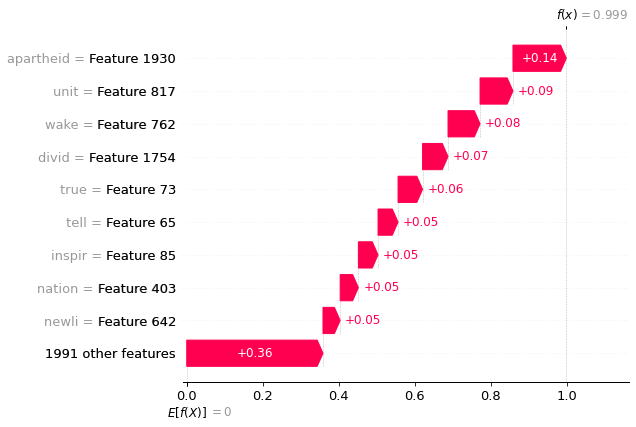

In [21]:
cs42 = [columns_idx_dict[c] for c in ['Sports and Fitness']]
plot_waterfall(i=1, columns=cs42, explainer=exp42, shap_values=shap_matrix42, 
               word_list = wl42, y_preds=yp42)